## **1D Heat Equation Physics-Informed Neural Network (PINN)**

---
In this notebook, we tackle an inverse problem involving the heat equation, a fundamental partial differential equation governing thermal diffusion in materials. Using a Physics-Informed Neural Network (PINN), we aim to simultaneously learn the temperature field

$T(x,t)$ and the unknown thermal parameters of the system.

Unlike a standard forward simulation; where the thermal diffusivity is known and we solve for $T(x,t)$, here we attempt to discover the underlying thermal behavior directly from data, while ensuring that the learned solution obeys the physics of heat transfer everywhere in the domain.

**Problem Setup** We consider the one-dimensional heat equation on a spatial domain $x \in [0,L]$ over a time interval $t \in [0,T]$

$$ T_t(x,t) - \alpha\,T_{xx}(x,t) - Q(x,t) = 0$$

where:


*   $T(x,t)$ is the temperature field,
*   $\alpha$ is the **thermal diffusivity**,
*   $Q(x,t)$ is an internal heat-generation term

In this inverse problem, the thermal diffusivity $\alpha$ is treated as unknown and must be learned from sparse and possibly noisy temperature measurements.

We also assume initial and boundary conditions:


*   **Initial condition:** $T(x,0)=T_0(x)$
* **Boundary conditions:** $T(0,t)=T(L,t)=T_{ambient}$







In [50]:
# Importing other libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
# --------------------------------------------------------
# PHYSICAL SETUP (HEAT EQUATION)
# --------------------------------------------------------
# we define a simple analytic solution of the 1D heat equation on [0, L] x [0, T_final]
#   to generate synthetic temperature data for (x, t).

L = 1.0          # length of the 1D battery layer
T_final = 1.0    # final time

# True physical diffusivity used to generate synthetic data
alpha_true = 0.1

Q0 = 0.0         # internal heat generation; set to 0 for now

# Trainable diffusivity parameter for the PINN (initial guess can be anything)
alpha_param = torch.nn.Parameter(torch.tensor([0.05], device=device))

# Ground truth analytic solution that satisfies the heat equation
def analytic_solution(x, t):
    return torch.exp(-(np.pi**2 * alpha_true / L**2) * t) * torch.sin(np.pi * x / L)

def heat_source(x, t): #For now, we assume Q(x,t) = 0 (no internal heat generation).
  return torch.zeros_like(x)

### Generate noisy data


In [52]:
# --------------------------------------------------------
# GENERATE SYNTHETIC "MEASUREMENT" DATA
# --------------------------------------------------------
#   Previously: we generated noisy samples (X, Y) from the quadratic ground_truth(x).
#   Now: we generate noisy temperature samples at random (x, t) locations.

torch.manual_seed(0)

n_data = 10  # number of synthetic temperature measurements
x_data = torch.rand(n_data, 1) * L            # x in [0, L]
t_data = torch.rand(n_data, 1) * T_final      # t in [0, T_final]

T_clean = analytic_solution(x_data, t_data)
noise_std = 0.01
T_data = T_clean + noise_std * torch.randn_like(T_clean)

x_data = x_data.to(device)
t_data = t_data.to(device)
T_data = T_data.to(device)


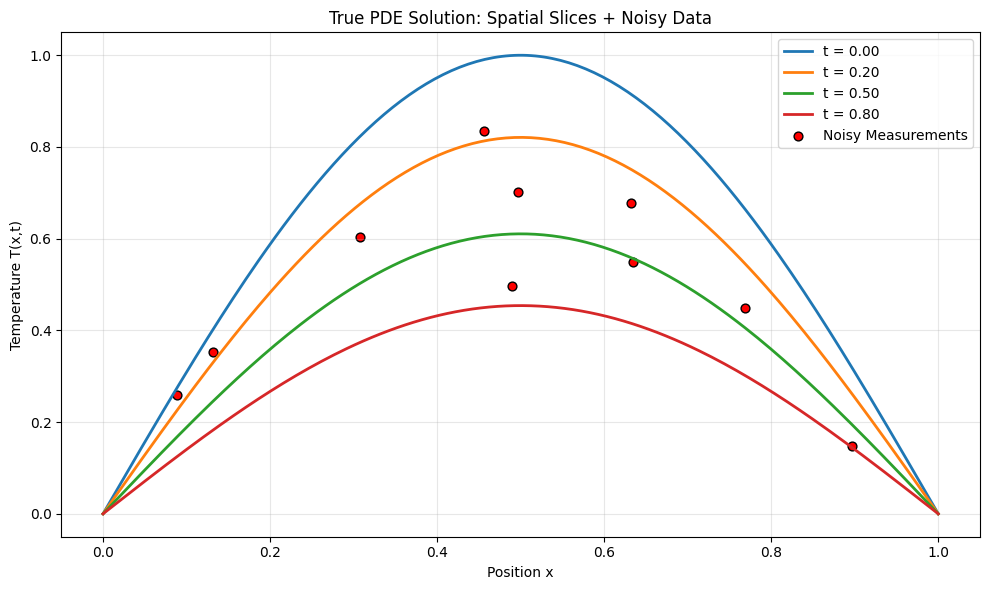

In [53]:
# --------------------------------------------------------
# MULTIPLE TIME-SLICE CURVE PLOT + NOISY DATA
# --------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

# Time slices to plot
times_to_plot = [0.0, 0.2*T_final, 0.5*T_final, 0.8*T_final]

x = torch.linspace(0, L, 200).view(-1, 1)

plt.figure(figsize=(10, 6))

for t0 in times_to_plot:
    t_val = torch.full_like(x, t0)
    T_slice = analytic_solution(x, t_val).detach().cpu().numpy()
    plt.plot(
        x.cpu().numpy(),
        T_slice,
        linewidth=2,
        label=f"t = {t0:.2f}"
    )

# Plot noisy data on top
plt.scatter(
    x_data.cpu().numpy(),
    T_data.cpu().numpy(),
    c='red',
    s=40,
    edgecolor='k',
    label='Noisy Measurements'
)

plt.xlabel("Position x")
plt.ylabel("Temperature T(x,t)")
plt.title("True PDE Solution: Spatial Slices + Noisy Data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Define Neural Network

In [54]:
# --------------------------------------------------------
# DEFINE NEURAL NETWORK
# --------------------------------------------------------
#   Previously Net took a single input x and output f(x).
#   Now Net takes 2D input [x, t] and outputs T(x,t).

class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        net = []
        for i in range(len(layers) - 1):
            net.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                net.append(nn.Tanh())
        self.net = nn.Sequential(*net)

    def forward(self, x, t):
        # x, t: (N, 1)
        XT = torch.cat([x, t], dim=1)  # (N, 2)
        return self.net(XT)


# Network architecture: 2 inputs (x,t), several hidden layers, 1 output (T)
layers = [2, 20, 20, 20, 1]
model = Net(layers).to(device)

# --------------------------------------------------------
# BASELINE MODEL (DATA-ONLY NEURAL NETWORK)
# --------------------------------------------------------
# This model has the same architecture but will NOT use any PDE/IC/BC losses.
baseline_layers = [2, 20, 20, 20, 1]
baseline_model = Net(baseline_layers).to(device)


In [55]:
# --------------------------------------------------------
# PINN LOSS COMPONENTS
# --------------------------------------------------------
mse_loss = nn.MSELoss()

def pde_residual(x_f, t_f):

    # CHANGE FROM QUADRATIC VERSION:
    #   Previously: residual = f''(x) - 2a  (an ODE constraint).
    #   Now: residual = T_t - alpha T_xx - Q(x,t)  (1D heat equation).

    x_f = x_f.clone().detach().requires_grad_(True).to(device)
    t_f = t_f.clone().detach().requires_grad_(True).to(device)

    T = model(x_f, t_f)

# First derivative w.r.t. t
    T_t = torch.autograd.grad(
        T, t_f,
        grad_outputs=torch.ones_like(T),
        create_graph=True,
        retain_graph=True
    )[0]

# First derivative w.r.t. x
    T_x = torch.autograd.grad(
        T, x_f,
        grad_outputs=torch.ones_like(T),
        create_graph=True,
        retain_graph=True
    )[0]

# Second derivative w.r.t. x
    T_xx = torch.autograd.grad(
        T_x, x_f,
        grad_outputs=torch.ones_like(T_x),
        create_graph=True,
        retain_graph=True
    )[0]

    Q = heat_source(x_f, t_f)

    res = T_t - alpha_param * T_xx - Q
    return res


def initial_condition(x_ic):

      #  Instead of specifying f(x) at endpoints, we now enforce:
      #  T(x,0) = sin(pi x / L)

    return analytic_solution(x_ic, torch.zeros_like(x_ic))


### Training Objective

Our goal is to simultaneously learn:

The neural network parameters $W$ that represent the temperature field $T(x,t;W)$, and the physical parameter $\alpha$ (thermal diffusivity), treated as a trainable variable.

Such that the network fits the observed temperature data:

*   The heat equation residual is minimized throughout the domain
*   The initial and boundary conditions are satisfied
*   We correctly discover the underlying thermal diffusivity governing the system
$$\qquad$$

The Physics-Informed Neural Network (PINN) enforces the governing PDE,
initial condition, boundary conditions, and data fidelity through a
weighted loss function composed of four terms.
$$\qquad$$


**PDE Loss:**
The PDE residual is defined as
$$ R(x,t)=T_t(x,t)- \alpha\,T_{xx}(x,t)- Q(x,t)$$
and the physics loss is the mean-squared residual over all collocation points:
$$
L_{\text{PDE}}
=
\frac{1}{N_f}
\sum_{i=1}^{N_f}
\left[
T_t\!\left(x_f^{(i)}, t_f^{(i)}\right)
- \alpha\,T_{xx}\!\left(x_f^{(i)}, t_f^{(i)}\right)
- Q\!\left(x_f^{(i)}, t_f^{(i)}\right)
\right]^2 .
$$
$$\qquad$$

**Initial Condition Loss:**
Given the initial condition $T(x,0) = T_0(x)$ the loss is

$$L_{IC}
=
\frac{1}{N_{IC}}
\sum_{i=1}^{N_{\text{IC}}}
\left[
T\!\left( x_{IC}^{(i)}, 0 \right)
-
T_0\!\left( x_{IC}^{(i)} \right)
\right]^2 .
$$

$$\qquad$$

**Boundary Condition Loss:**
Assuming Dirichlet boundary conditions $T(0,t) = T_{bc}\;$ and
$\;T(L,t) = T_{bc}$

the boundary loss becomes
$$L_{BC}
=
\frac{1}{N_{BC}}
\sum_{i=1}^{N_{BC}}
\left[
\left( T(0, t_{\text{BC}}^{(i)}) - T_{\text{bc}} \right)^2
+
\left( T(L, t_{\text{BC}}^{(i)}) - T_{\text{bc}} \right)^2
\right]$$
$$\qquad$$


**Data Loss:**
Given noisy temperature measurements $(x_d^{(i)}, t_d^{(i)}, T_d^{(i)})$, the data loss is
$$L_{data}
=
\frac{1}{N_{data}}
\sum_{i=1}^{N_{data}}
\left[
T\!\left( x_d^{(i)}, t_d^{(i)} \right)
- T_d^{(i)}
\right]^2 .
$$
$$\qquad$$



**Total Loss:**
The complete PINN loss function is a weighted sum of all components:
$$
L_{total}
=
\lambda_{PDE}\,L_{PDE}
+
\lambda_{IC}\,L_{IC}
+
\lambda_{BC}\,L_{BC}
+
\lambda_{data}\, L_{data}$$

The coefficients $\lambda_{PDE}, \lambda_{IC}, \lambda_{BC}, \lambda_{data}$
control the balance between physics enforcement and data fitting.


In [56]:
# --------------------------------------------------------
# TRAINING FUNCTION
# --------------------------------------------------------
#   - Inputs are now (x, t) for data and residual points.
#   - We add explicit initial and boundary condition losses.
#   - The physics loss term now uses pde_residual instead of f''(x).

def train(model, optimizer, epochs, eta_phys,
          N_f=200, N_ic=50, N_bc=50):
    data_losses = []
    physics_losses = []
    ic_losses = []
    bc_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # -------------------------
        # Data loss: fit noisy T_data at (x_data, t_data)
        # -------------------------
        T_pred_data = model(x_data, t_data)
        loss_data = mse_loss(T_pred_data, T_data)

        # -------------------------
        # Physics loss: PDE residual at collocation points
        # -------------------------
        x_f = torch.rand(N_f, 1) * L
        t_f = torch.rand(N_f, 1) * T_final
        x_f = x_f.to(device)
        t_f = t_f.to(device)

        res_f = pde_residual(x_f, t_f)
        loss_phys = (res_f ** 2).mean()

        # -------------------------
        # Initial condition loss: T(x,0) = sin(pi x / L)
        # -------------------------
        x_ic = torch.rand(N_ic, 1) * L
        t_ic = torch.zeros_like(x_ic)
        x_ic = x_ic.to(device)
        t_ic = t_ic.to(device)

        T_pred_ic = model(x_ic, t_ic)
        T_true_ic = initial_condition(x_ic)
        loss_ic = mse_loss(T_pred_ic, T_true_ic)

        # -------------------------
        # Boundary condition loss: T(0,t) = 0, T(L,t) = 0
        # -------------------------
        t_bc = torch.rand(N_bc, 1) * T_final
        t_bc = t_bc.to(device)

        x_bc0 = torch.zeros_like(t_bc).to(device)
        x_bcL = (L * torch.ones_like(t_bc)).to(device)

        T_bc0 = model(x_bc0, t_bc)
        T_bcL = model(x_bcL, t_bc)

        loss_bc = mse_loss(T_bc0, torch.zeros_like(T_bc0)) + \
                  mse_loss(T_bcL, torch.zeros_like(T_bcL))

        # -------------------------
        # Total loss
        # -------------------------
        total_loss = loss_data + eta_phys * loss_phys + loss_ic + loss_bc

        total_loss.backward()
        optimizer.step()

        data_losses.append(loss_data.item())
        physics_losses.append(loss_phys.item())
        ic_losses.append(loss_ic.item())
        bc_losses.append(loss_bc.item())

        if epoch % 500 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:5d} | "
                  f"Total: {total_loss.item():.4e} | "
                  f"Data: {loss_data.item():.4e} | "
                  f"PDE: {loss_phys.item():.4e} | "
                  f"IC: {loss_ic.item():.4e} | "
                  f"BC: {loss_bc.item():.4e}")

    return data_losses, physics_losses, ic_losses, bc_losses

# --------------------------------------------------------
# BASELINE TRAINING FUNCTION (DATA-ONLY)
# --------------------------------------------------------
def train_baseline(model, optimizer, epochs):
    """
    Train a data-only neural network on (x_data, t_data, T_data)
    using plain MSE loss, no physics/IC/BC terms.
    """
    baseline_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Data loss only: fit noisy T_data at (x_data, t_data)
        T_pred = model(x_data, t_data)
        loss = mse_loss(T_pred, T_data)

        loss.backward()
        optimizer.step()

        baseline_losses.append(loss.item())

        if epoch % 500 == 0 or epoch == epochs - 1:
            print(f"[Baseline] Epoch {epoch:5d} | Data loss: {loss.item():.4e}")

    return baseline_losses

In [57]:
# --------------------------------------------------------
# TRAIN BASELINE MODEL (DATA-ONLY)
# --------------------------------------------------------
baseline_epochs = 5000
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=1e-3)
baseline_losses = train_baseline(baseline_model, baseline_optimizer, baseline_epochs)

# --------------------------------------------------------
# TRAIN PINN MODEL (WITH PHYSICS)
# --------------------------------------------------------
epochs = 5000
eta_phys = 1
optimizer = optim.Adam(list(model.parameters()) + [alpha_param], lr=1e-3)
data_losses, physics_losses, ic_losses, bc_losses = train(model, optimizer, epochs, eta_phys)

[Baseline] Epoch     0 | Data loss: 4.5629e-01
[Baseline] Epoch   500 | Data loss: 6.3638e-03
[Baseline] Epoch  1000 | Data loss: 3.1890e-04
[Baseline] Epoch  1500 | Data loss: 5.9527e-05
[Baseline] Epoch  2000 | Data loss: 3.2439e-05
[Baseline] Epoch  2500 | Data loss: 2.1421e-05
[Baseline] Epoch  3000 | Data loss: 1.4475e-05
[Baseline] Epoch  3500 | Data loss: 7.5828e-06
[Baseline] Epoch  4000 | Data loss: 1.8511e-05
[Baseline] Epoch  4500 | Data loss: 2.3043e-06
[Baseline] Epoch  4999 | Data loss: 1.2132e-06
Epoch     0 | Total: 9.1498e-01 | Data: 3.3325e-01 | PDE: 1.6636e-03 | IC: 5.7599e-01 | BC: 4.0781e-03
Epoch   500 | Total: 7.2259e-03 | Data: 1.2732e-03 | PDE: 3.1594e-03 | IC: 2.3143e-03 | BC: 4.7898e-04
Epoch  1000 | Total: 5.0797e-04 | Data: 7.2276e-05 | PDE: 1.7943e-04 | IC: 8.6525e-05 | BC: 1.6974e-04
Epoch  1500 | Total: 3.7434e-04 | Data: 4.3737e-05 | PDE: 1.7094e-04 | IC: 4.5147e-05 | BC: 1.1452e-04
Epoch  2000 | Total: 2.4342e-04 | Data: 6.1584e-05 | PDE: 6.3482e-05 | 

### Visualization


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

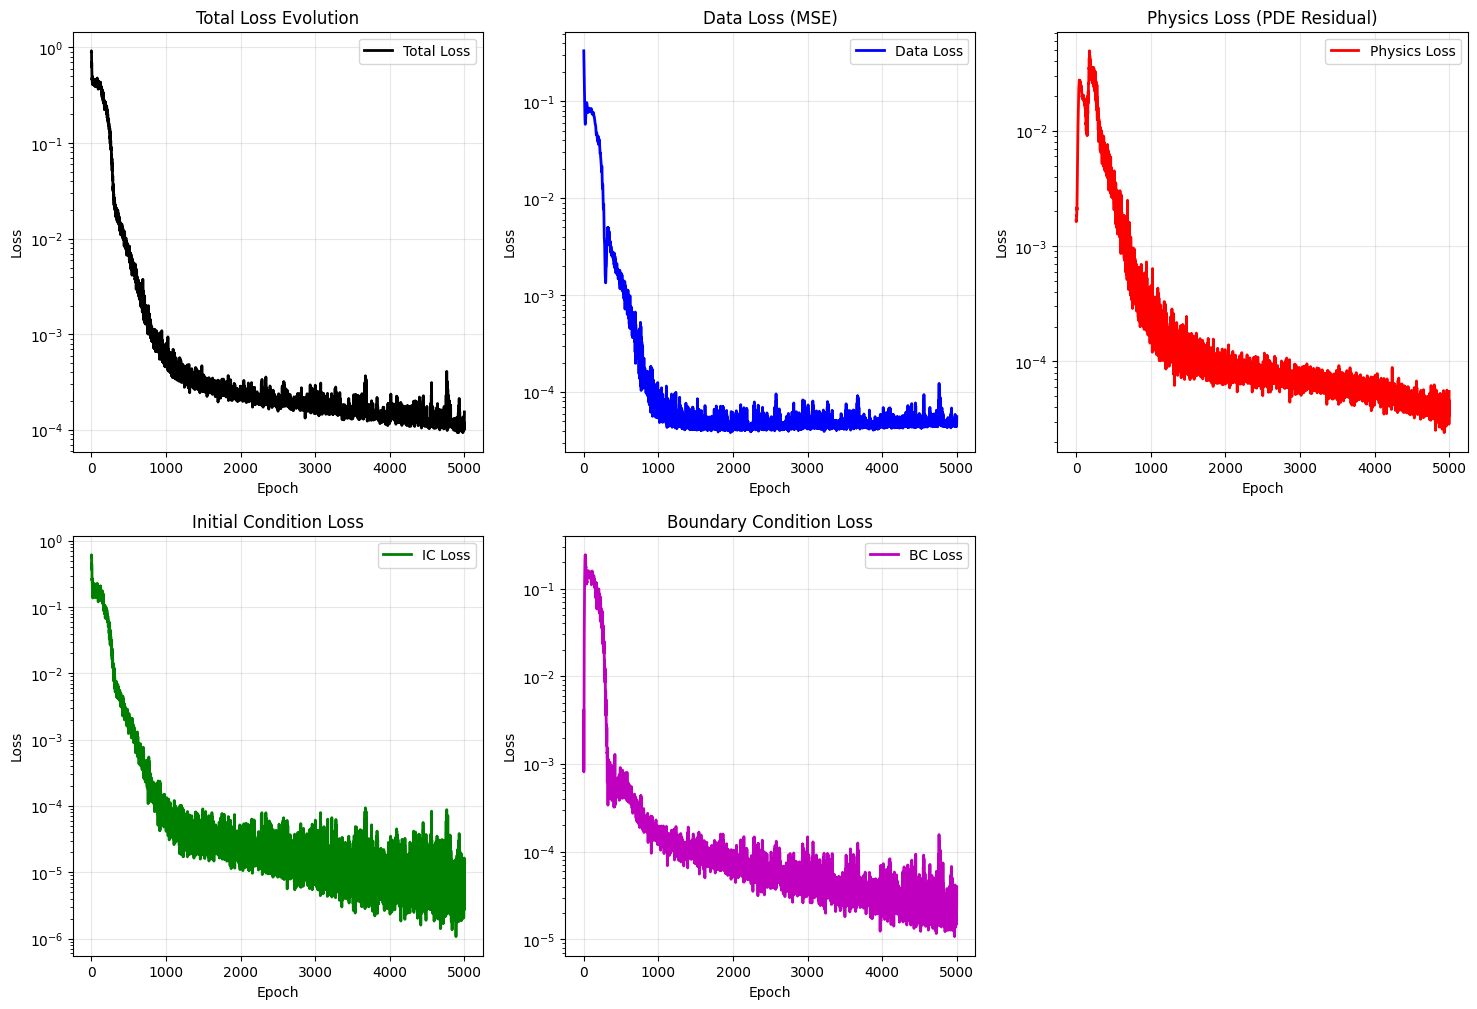

In [58]:
# ============================================
# Loss visualization for Heat Equation PINN
# ============================================

import matplotlib.pyplot as plt

# Reconstruct total loss from components
# ------ make sure eta_phys matches what was used in training ------ #
lambda_pde  = eta_phys
lambda_ic   = 1.0
lambda_bc   = 1.0
lambda_data = 1.0

num_epochs = len(data_losses)
epochs_range = range(num_epochs)

total_losses = [
    lambda_pde  * physics_losses[i] +
    lambda_ic   * ic_losses[i] +
    lambda_bc   * bc_losses[i] +
    lambda_data * data_losses[i]
    for i in range(num_epochs)
]

# Create 2x3 grid: Total, PDE, Data, IC, BC (last panel unused or for notes)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

# ---- Total loss ----
ax1.plot(epochs_range, total_losses, 'k-', linewidth=2, label='Total Loss')
ax1.set_title('Total Loss Evolution')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

# ---- Data loss ----
ax2.plot(epochs_range, data_losses, 'b-', linewidth=2, label='Data Loss')
ax2.set_title('Data Loss (MSE)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.legend()

# ---- Physics (PDE) loss ----
ax3.plot(epochs_range, physics_losses, 'r-', linewidth=2, label='Physics Loss')
ax3.set_title('Physics Loss (PDE Residual)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)
ax3.legend()

# ---- Initial condition loss ----
ax4.plot(epochs_range, ic_losses, 'g-', linewidth=2, label='IC Loss')
ax4.set_title('Initial Condition Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)
ax4.legend()

# ---- Boundary condition loss ----
ax5.plot(epochs_range, bc_losses, 'm-', linewidth=2, label='BC Loss')
ax5.set_title('Boundary Condition Loss')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Loss')
ax5.set_yscale('log')
ax5.grid(True, alpha=0.3)
ax5.legend()


ax6.axis('off')



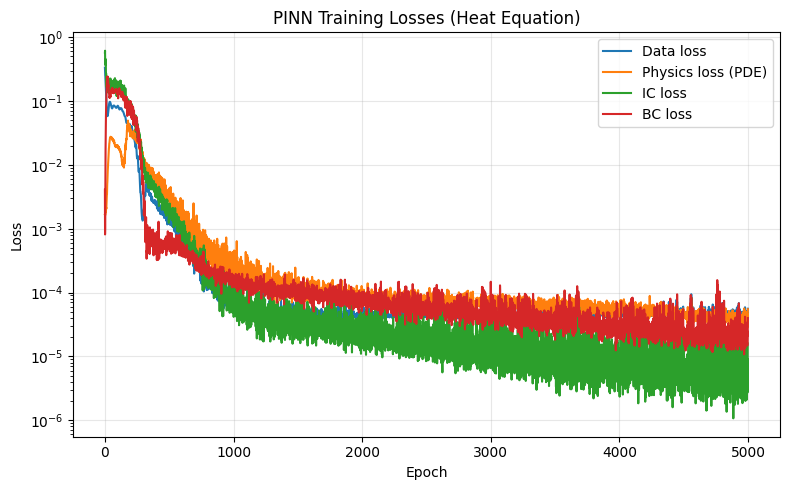

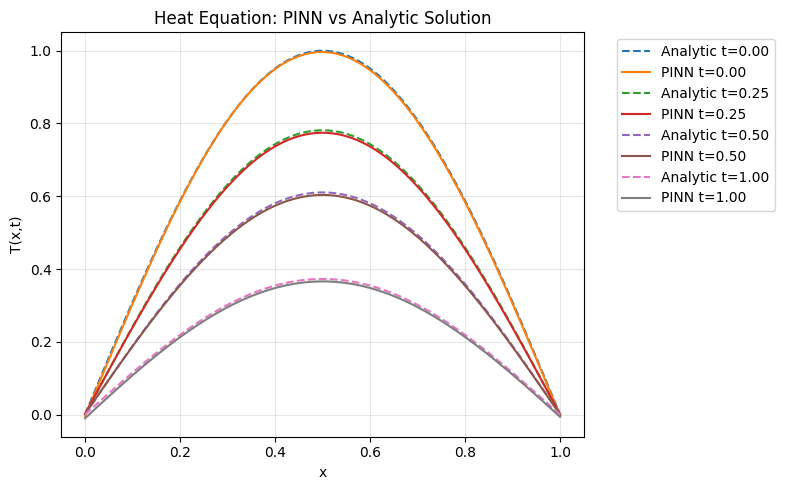

In [59]:
# --------------------------------------------------------
# VISUALIZATION
# --------------------------------------------------------
#   we now plot T(x,t) slices and compare to the analytic heat-equation solution.

# 1) Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(data_losses, label="Data loss")
plt.plot(physics_losses, label="Physics loss (PDE)")
plt.plot(ic_losses, label="IC loss")
plt.plot(bc_losses, label="BC loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PINN Training Losses (Heat Equation)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Compare PINN vs analytic solution at several time slices
x_plot = torch.linspace(0, L, 200).view(-1, 1).to(device)
times_to_plot = [0.0, 0.25 * T_final, 0.5 * T_final, T_final]

plt.figure(figsize=(8,5))
for t_val in times_to_plot:
    t_plot = torch.full_like(x_plot, t_val).to(device)

    with torch.no_grad():
        T_pinn = model(x_plot, t_plot).cpu()
        T_true = analytic_solution(x_plot.cpu(), t_plot.cpu())

    plt.plot(x_plot.cpu().numpy(), T_true.numpy(),
             linestyle="--", label=f"Analytic t={t_val:.2f}")
    plt.plot(x_plot.cpu().numpy(), T_pinn.numpy(),
             linestyle="-", label=f"PINN t={t_val:.2f}")

plt.xlabel("x")
plt.ylabel("T(x,t)")
plt.title("Heat Equation: PINN vs Analytic Solution")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [61]:
# --------------------------------------------------------
# EVALUATE BASELINE VS PINN ON A TEST GRID
# --------------------------------------------------------

# Build a grid of evaluation points
Nx_eval, Nt_eval = 60, 60
x_eval = torch.linspace(0.0, L, Nx_eval).view(-1, 1)
t_eval = torch.linspace(0.0, T_final, Nt_eval).view(-1, 1)

Xg_eval, Tg_eval = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing="ij")
x_flat = Xg_eval.reshape(-1, 1)
t_flat = Tg_eval.reshape(-1, 1)

x_flat_d = x_flat.to(device)
t_flat_d = t_flat.to(device)

with torch.no_grad():
    # True solution on the grid
    T_true = analytic_solution(x_flat, t_flat).to(device)

    # PINN prediction
    T_pinn = model(x_flat_d, t_flat_d).cpu().to(device)

    # Baseline prediction
    T_base = baseline_model(x_flat_d, t_flat_d).cpu().to(device)

# Compute mean squared error for each model
mse_pinn = torch.mean((T_pinn - T_true)**2).item()
mse_base = torch.mean((T_base - T_true)**2).item()

improvement_pct = 100.0 * (mse_base - mse_pinn) / mse_base

print("\n=== Baseline vs PINN Comparison (Heat Equation) ===")
print(f"Baseline MSE (data-only NN): {mse_base:.4e}")
print(f"PINN MSE (with physics):     {mse_pinn:.4e}")
print(f"Relative error reduction:    {improvement_pct:.2f}%")



=== Baseline vs PINN Comparison (Heat Equation) ===
Baseline MSE (data-only NN): 4.6806e-03
PINN MSE (with physics):     2.4447e-05
Relative error reduction:    99.48%


The heatmap displays the temperature field predicted by the PINN for the 1D heat equation.

The PINN correctly reproduces the initial temperature profile:

$$T(x,0)=sin(πx)$$

This appears in the heatmap as a bright high-temperature region centered at $x = 0.5$ and zero temperature at $x = 0$ and $x = 1$.


This behavior matches the analytical solution:
$$T(x,t)=e^{−\pi^2 \alpha t} \sin(\pi x)$$
$$\qquad$$

The predicted temperature field is: smooth in both $x$ and $t$, symmetric about $x = 0.5$, free of noise, and consistent with heat-equation physics.


The 2-D heatmap demonstrates that the PINN successfully:

* learned the initial condition

* enforced the boundary conditions

* captured the correct diffusion behavior

* produced a smooth, physically valid temperature evolution across the domain

In [62]:
alpha_learned = float(alpha_param.detach().cpu().item())
alpha_error_pct = 100.0 * abs(alpha_learned - alpha_true) / alpha_true

print("\n=== Learned Diffusivity (Trainable PINN) ===")
print(f"True alpha:    {alpha_true:.6f}")
print(f"Learned alpha: {alpha_learned:.6f}")
print(f"Percent error: {alpha_error_pct:.3f}%")



=== Learned Diffusivity (Trainable PINN) ===
True alpha:    0.100000
Learned alpha: 0.101494
Percent error: 1.494%


### Post-Processing Analysis

Now we'll analyze the learned network to extract the linear relationship parameters (slope and intercept) and examine their statistical properties.

In [63]:
# --------------------------------------------------------
# POST-PROCESSING: Analyze learned PDE parameter alpha
# --------------------------------------------------------
# CHANGE FROM QUADRATIC VERSION:
#   Previously:
#       - You analyzed f(x) and its derivatives to extract a, b, c
#         in y ≈ a x^2 + b x + c.
#   Now:
#       - We analyze T(x,t), T_t, and T_xx across the domain
#         to extract an effective alpha_hat(x,t) from:
#               T_t ≈ alpha * T_xx  =>  alpha_hat ≈ T_t / T_xx
#       - Then we look at statistics of alpha_hat and compare to alpha_true.

print("\n" + "="*70)
print("POST-PROCESSING: PDE Parameter (alpha) Analysis")
print("="*70)

# Step 1: set analysis grid in (x, t)
Nx, Nt = 40, 40  # you can increase for smoother stats
x_vals = torch.linspace(0.0, L, Nx).view(-1, 1)
t_vals = torch.linspace(0.0, T_final, Nt).view(-1, 1)

Xg, Tg = torch.meshgrid(x_vals.squeeze(), t_vals.squeeze(), indexing="ij")
x_analysis = Xg.reshape(-1, 1).to(device)
t_analysis = Tg.reshape(-1, 1).to(device)

# We need gradients w.r.t x and t
x_analysis.requires_grad_(True)
t_analysis.requires_grad_(True)

# Step 2: evaluate network and its derivatives
T_analysis = model(x_analysis, t_analysis)

T_t_analysis = torch.autograd.grad(
    T_analysis, t_analysis,
    grad_outputs=torch.ones_like(T_analysis),
    create_graph=True, retain_graph=True
)[0]

T_x_analysis = torch.autograd.grad(
    T_analysis, x_analysis,
    grad_outputs=torch.ones_like(T_analysis),
    create_graph=True, retain_graph=True
)[0]

T_xx_analysis = torch.autograd.grad(
    T_x_analysis, x_analysis,
    grad_outputs=torch.ones_like(T_x_analysis),
    create_graph=True, retain_graph=True
)[0]

# If you are using Q(x,t) != 0, include it here:
Q_analysis = heat_source(x_analysis, t_analysis)

# Step 3: compute local alpha_hat(x,t) ≈ (T_t - Q) / T_xx
# Avoid dividing by very small T_xx to prevent numerical blow-up
with torch.no_grad():
    T_t_np  = T_t_analysis.cpu().numpy().flatten()
    T_xx_np = T_xx_analysis.cpu().numpy().flatten()
    Q_np    = Q_analysis.cpu().numpy().flatten()

import numpy as np

eps = 1e-6  # threshold for discarding near-zero second derivatives
mask = np.abs(T_xx_np) > eps

alpha_hat_vals = (T_t_np[mask] - Q_np[mask]) / T_xx_np[mask]

# Step 4: basic statistics of alpha_hat
alpha_hat_mean = float(np.mean(alpha_hat_vals))
alpha_hat_std  = float(np.std(alpha_hat_vals))

print("=== Local alpha_hat(x,t) samples (first 10) ===")
print(alpha_hat_vals[:10])

print("\n=== alpha statistics ===")
print(f"Mean alpha_hat: {alpha_hat_mean:.6f}")
print(f"Std  alpha_hat: {alpha_hat_std:.6f}")

# Compare with true alpha (used in the PDE)
alpha_true = alpha  # from your model setup
print("\n=== Comparison with ground truth alpha ===")
print(f"True alpha:      {alpha_true:.6f}")
print(f"|alpha_hat_mean - alpha_true| = {abs(alpha_hat_mean - alpha_true):.6f}")

# Step 5: residual diagnostics (how well PDE is satisfied)
# PDE residual: R(x,t) = T_t - alpha * T_xx - Q
R_np = T_t_np - alpha_true * T_xx_np - Q_np

print("\n=== PDE Residual Diagnostics ===")
print(f"Residual mean: {np.mean(R_np):.6e}")
print(f"Residual std:  {np.std(R_np):.6e}")
print(f"Residual max:  {np.max(np.abs(R_np)):.6e}")

print("\n=== Summary ===")
print("The PINN's learned temperature field T(x,t) implies a local")
print("effective diffusivity alpha_hat(x,t). If training was successful,")
print("alpha_hat_mean should be close to the true alpha used in the PDE,")
print("and the PDE residual statistics should be small.")
print("="*70 + "\n")



POST-PROCESSING: PDE Parameter (alpha) Analysis
=== Local alpha_hat(x,t) samples (first 10) ===
[ 0.07024683  0.08586701  0.10585095  0.1329269   0.17325705  0.24419296
  0.4195912   2.013645   -0.56529486 -0.2102575 ]

=== alpha statistics ===
Mean alpha_hat: 0.097900
Std  alpha_hat: 0.070794

=== Comparison with ground truth alpha ===
True alpha:      0.100000
|alpha_hat_mean - alpha_true| = 0.002100

=== PDE Residual Diagnostics ===
Residual mean: -5.167429e-03
Residual std:  8.171834e-03
Residual max:  3.199178e-02

=== Summary ===
The PINN's learned temperature field T(x,t) implies a local
effective diffusivity alpha_hat(x,t). If training was successful,
alpha_hat_mean should be close to the true alpha used in the PDE,
and the PDE residual statistics should be small.



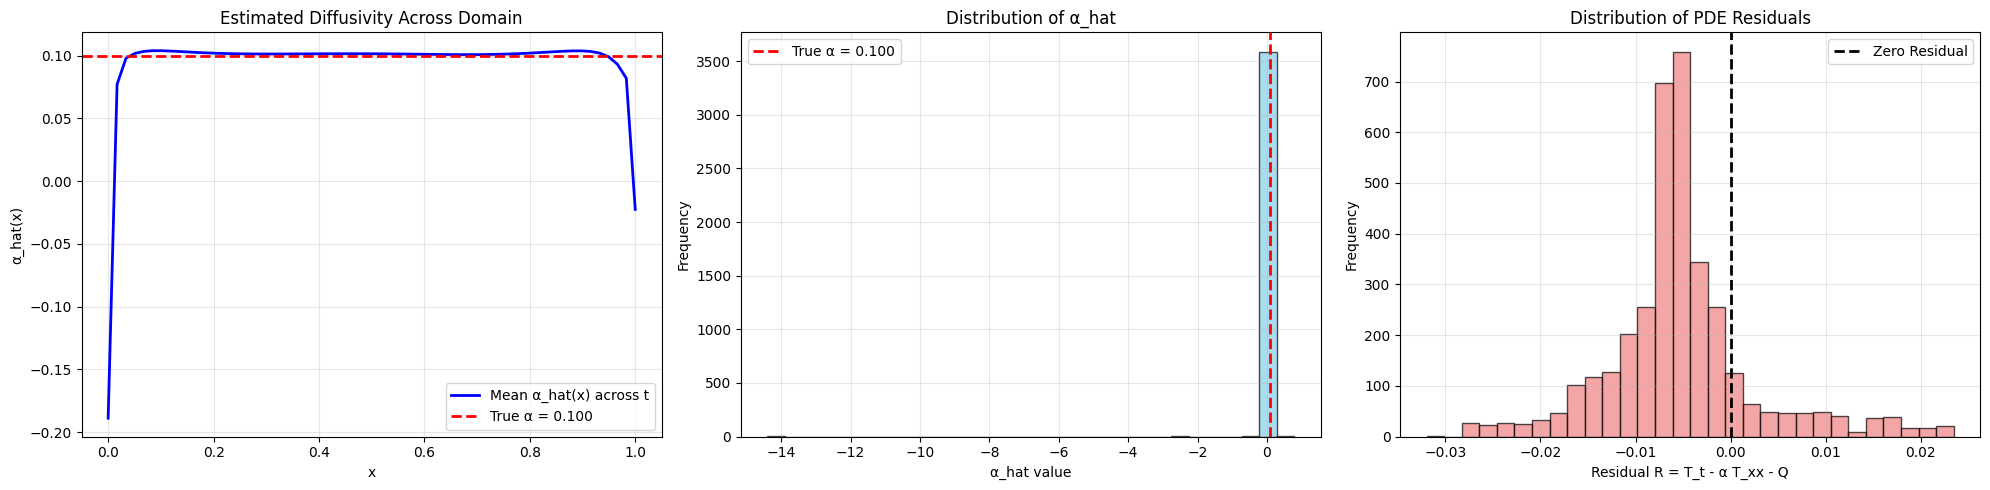


=== Final Summary Statistics (Heat Equation) ===
True alpha:             0.100000
alpha_hat mean:         0.093991
alpha_hat std:          0.246621
Mean PDE residual:      -5.370778e-03
Std PDE residual:       7.815436e-03
Max |PDE residual|:     3.199178e-02


In [64]:
# --------------------------------------------------------
# FINAL VISUALIZATION: Three diagnostic plots (Heat Equation)
# --------------------------------------------------------
# CHANGE FROM QUADRATIC VERSION:
#   Quadratic Version:
#       1) f''(x) plot
#       2) histogram of f''
#       3) histogram of residuals after quadratic regression
#
#   Heat Equation Version:
#       1) α_hat(x,t) distribution across the domain
#       2) histogram of α_hat values
#       3) histogram of PDE residuals R(x,t)
#
#   These mimic the structure of your 3-panel quadratic visualization.

import numpy as np
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# --------------------------------------------------------
# Recompute T_t, T_xx, residuals on a dense analysis grid
# --------------------------------------------------------
Nx, Nt = 60, 60
x_vals = torch.linspace(0.0, L, Nx).view(-1, 1)
t_vals = torch.linspace(0.0, T_final, Nt).view(-1, 1)

Xg, Tg = torch.meshgrid(x_vals.squeeze(), t_vals.squeeze(), indexing="ij")
xA = Xg.reshape(-1, 1).to(device)
tA = Tg.reshape(-1, 1).to(device)

xA.requires_grad_(True)
tA.requires_grad_(True)

T_A  = model(xA, tA)
T_tA = torch.autograd.grad(T_A, tA,
            grad_outputs=torch.ones_like(T_A),
            create_graph=True, retain_graph=True)[0]
T_xA = torch.autograd.grad(T_A, xA,
            grad_outputs=torch.ones_like(T_A),
            create_graph=True, retain_graph=True)[0]
T_xxA = torch.autograd.grad(T_xA, xA,
            grad_outputs=torch.ones_like(T_xA),
            create_graph=True, retain_graph=True)[0]

Q_A = heat_source(xA, tA)

# α_hat values (avoid tiny denominators)
T_t_np  = T_tA.detach().cpu().numpy().flatten()
T_xx_np = T_xxA.detach().cpu().numpy().flatten()
Q_np    = Q_A.detach().cpu().numpy().flatten()

eps = 1e-6
mask = np.abs(T_xx_np) > eps

alpha_hat_vals = (T_t_np[mask] - Q_np[mask]) / T_xx_np[mask]

# PDE residuals: R(x,t) = T_t - alpha_true T_xx - Q
R_vals = T_t_np - alpha_true * T_xx_np - Q_np


# --------------------------------------------------------
# Plot 1: α_hat(x,t) as a function of x (averaged over t)
# --------------------------------------------------------
alpha_hat_grid = alpha_hat_vals.reshape(-1)

# Average α_hat at each x across t
alpha_matrix = (alpha_hat_vals).reshape(Nx, Nt)
alpha_x_mean = np.mean(alpha_matrix, axis=1)

ax1.plot(x_vals.cpu().numpy(), alpha_x_mean, 'b-', linewidth=2,
         label='Mean α_hat(x) across t')

ax1.axhline(y=alpha, color='r', linestyle='--', linewidth=2,
            label=f'True α = {alpha:.3f}')

ax1.set_xlabel('x')
ax1.set_ylabel('α_hat(x)')
ax1.set_title('Estimated Diffusivity Across Domain')
ax1.grid(True, alpha=0.3)
ax1.legend()


# --------------------------------------------------------
# Plot 2: Histogram of α_hat
# --------------------------------------------------------
ax2.hist(alpha_hat_vals, bins=30, alpha=0.7,
         color='skyblue', edgecolor='black')

ax2.axvline(alpha, color='r', linestyle='--', linewidth=2,
            label=f'True α = {alpha:.3f}')

ax2.set_xlabel('α_hat value')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of α_hat')
ax2.grid(True, alpha=0.3)
ax2.legend()


# --------------------------------------------------------
# Plot 3: Histogram of PDE residuals
# --------------------------------------------------------
ax3.hist(R_vals, bins=30, alpha=0.7,
         color='lightcoral', edgecolor='black')

ax3.axvline(0.0, color='k', linestyle='--', linewidth=2,
            label='Zero Residual')

ax3.set_xlabel('Residual R = T_t - α T_xx - Q')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of PDE Residuals')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

# --------------------------------------------------------
# Summary statistics (similar to quadratic version)
# --------------------------------------------------------
print("\n=== Final Summary Statistics (Heat Equation) ===")
print(f"True alpha:             {alpha:.6f}")
print(f"alpha_hat mean:         {np.mean(alpha_hat_vals):.6f}")
print(f"alpha_hat std:          {np.std(alpha_hat_vals):.6f}")
print(f"Mean PDE residual:      {np.mean(R_vals):.6e}")
print(f"Std PDE residual:       {np.std(R_vals):.6e}")
print(f"Max |PDE residual|:     {np.max(np.abs(R_vals)):.6e}")
